# Install Dependencies

In [81]:
%pip install torch_snippets torch_summary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Libraries

In [82]:
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch_snippets import *
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import cv2
from glob import glob
import pandas as pd

sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [83]:
DIR = "D:/NIK_CINICHKA/HH/HAR/"
TRAIN_DIR=f"{DIR}train"
TEST_DIR=f"{DIR}test"
TRAIN_VAL_DF = "D:/NIK_CINICHKA/HH/HAR/Training_set.csv"


In [84]:
train_val_data=glob(TRAIN_DIR+'/*.jpg')
# remove duplicate
train_data, val_data = train_test_split(train_val_data, test_size=0.15, shuffle=True)
print('Train Size', len(train_data))
print('Val Size', len(val_data))

Train Size 10710
Val Size 1890


In [85]:
df=pd.read_csv(f"{DIR}Training_set.csv")
df.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [86]:
agg_labels = df.groupby('label').agg({'label': 'count'})
agg_labels.rename(columns={'label': 'count'})

,count
label,
calling,840
clapping,840
cycling,840
dancing,840
drinking,840
eating,840
fighting,840
hugging,840
laughing,840


In [87]:
ind2cat = sorted(df['label'].unique().tolist())
cat2ind = {cat: ind for ind, cat in enumerate(ind2cat)}

In [88]:
class HumanActionData(Dataset):
    def __init__(self, file_paths, df_path, cat2ind):
        super().__init__()
        self.file_paths = file_paths
        self.cat2ind = cat2ind
        self.df = pd.read_csv(df_path)
        self.transform = transforms.Compose([ 
            transforms.Resize([224, 244]), 
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229*255, 0.224*255, 0.225*255))]
        )
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, ind):
        file_path = self.file_paths[ind]
        
        file_name = os.path.basename(file_path)
        match = re.search(r'\d+', file_name)
        if match:
            itarget = int(match.group())
        else:
            raise ValueError(f"No numeric index found in file name: {file_name}")
    
        target = self.df.iloc[itarget-1]['label']
        target = self.cat2ind[target]
        
        img = Image.open(file_path).convert('RGB')
        return img, target
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        imgs = torch.stack([self.transform(img) for img in imgs], 0)
        imgs = imgs.to(device)
        targets = torch.tensor(targets).long().to(device)
        return imgs, targets
    
    def choose(self):
        return self[np.random.randint(len(self))]

In [99]:
train_ds = HumanActionData(train_data, TRAIN_VAL_DF, cat2ind)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,
                      collate_fn=train_ds.collate_fn,
                      drop_last=True)

val_ds = HumanActionData(val_data, TRAIN_VAL_DF, cat2ind)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True,
                    collate_fn=val_ds.collate_fn,
                    drop_last=True)

<PIL.Image.Image image mode=RGB size=259x194 at 0x1CAEF016790>


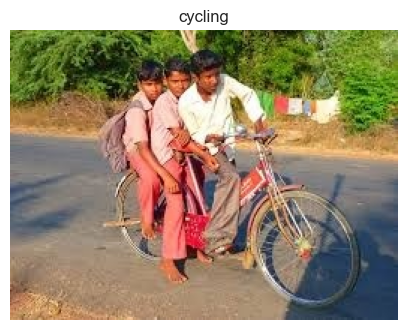

In [90]:
img, target = train_ds.choose()
print(img)
show(img, title=ind2cat[int(target)])

# Model

In [101]:
class ActionClassifier(nn.Module):
    def __init__(self, ntargets):
        super().__init__()
        resnet = models.resnet50(pretrained=True, progress=True)
        modules = list(resnet.children())[:-1] # delete last layer
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(resnet.fc.in_features),
            nn.Dropout(0.2),
            nn.Linear(resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, ntargets)
        )
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

In [102]:
classifier = ActionClassifier(len(ind2cat))
_ = summary(classifier, torch.zeros(32,3,224,224).to(device))

c:\Users\12700\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\12700\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         (75,008)
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         (70,400)
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         (70,400)
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         (379,392)
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         (280,064)
|    |    └─Bottleneck: 3-6              [-1,

## Train

In [103]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    preds = outputs.argmax(-1)
    acc = (sum(preds==targets) / len(targets))
    classifier.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, acc

In [104]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    preds = outputs.argmax(-1)
    acc = (sum(preds==targets) / len(targets))
    return loss, acc

In [105]:
import matplotlib.pyplot as plt

class Logger:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.epoch_loss = []  # Список для потерь
        self.epoch_accuracy = []  # Список для точности

    def record(self, epoch, batch, loss, accuracy, mode='train'):
        # потери и точность
        if mode == 'train':
            self.epoch_loss.append(loss)
            self.epoch_accuracy.append(accuracy)
        print(f'{mode.capitalize()} - Epoch {epoch+1}/{self.n_epochs}, Batch {batch+1}, '
              f'Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

    def log(self, epoch, loss, accuracy):
        print(f'Epoch {epoch+1}/{self.n_epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.2f}%')

    def report_avgs(self, epoch):
        print(f'Epoch {epoch} completed.')

    def plot_epochs(self, metrics):
        plt.figure(figsize=(10, 5))
        
        for metric in metrics:
            if metric == 'train_loss':
                plt.plot(self.epoch_loss, label='Train Loss', color='b')
            elif metric == 'val_loss':
                plt.plot(self.epoch_loss, label='Validation Loss', color='r')  
            elif metric == 'train_accuracy':
                plt.plot(self.epoch_accuracy, label='Train Accuracy', color='g')
            else:
                print(f"Metric {metric} not recognized.")
        
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.title('Metrics over Epochs')
        plt.legend()
        plt.show()


In [106]:
n_epochs = 36
log = Logger(n_epochs)
classifier = ActionClassifier(len(ind2cat)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                     gamma=0.5)

In [107]:
for epoch in range(n_epochs):
    
    for i, data in enumerate(train_dl):
        train_loss, train_acc = train(data, classifier, optimizer, loss_fn)
        log.record(epoch, i, train_loss, train_acc, mode='train')

    
    for i, data in enumerate(val_dl):
        val_loss, val_acc = validate(data, classifier, loss_fn)
        log.record(epoch, i, val_loss, val_acc, mode='val')

    scheduler.step()
    log.report_avgs(epoch+1)

Train - Epoch 1/36, Batch 1, Loss: 2.9373, Accuracy: 0.03%
Train - Epoch 1/36, Batch 2, Loss: 2.6070, Accuracy: 0.25%
Train - Epoch 1/36, Batch 3, Loss: 2.1714, Accuracy: 0.31%
Train - Epoch 1/36, Batch 4, Loss: 2.3603, Accuracy: 0.25%
Train - Epoch 1/36, Batch 5, Loss: 1.8589, Accuracy: 0.44%
Train - Epoch 1/36, Batch 6, Loss: 1.7217, Accuracy: 0.47%
Train - Epoch 1/36, Batch 7, Loss: 1.9055, Accuracy: 0.34%
Train - Epoch 1/36, Batch 8, Loss: 2.1478, Accuracy: 0.31%
Train - Epoch 1/36, Batch 9, Loss: 1.8828, Accuracy: 0.34%
Train - Epoch 1/36, Batch 10, Loss: 1.7139, Accuracy: 0.41%
Train - Epoch 1/36, Batch 11, Loss: 1.9663, Accuracy: 0.31%
Train - Epoch 1/36, Batch 12, Loss: 1.7680, Accuracy: 0.47%
Train - Epoch 1/36, Batch 13, Loss: 2.2707, Accuracy: 0.38%
Train - Epoch 1/36, Batch 14, Loss: 1.3987, Accuracy: 0.59%
Train - Epoch 1/36, Batch 15, Loss: 1.6113, Accuracy: 0.53%
Train - Epoch 1/36, Batch 16, Loss: 1.8412, Accuracy: 0.41%
Train - Epoch 1/36, Batch 17, Loss: 1.6307, Accur

In [109]:
%mkdir saved_model
torch.save(classifier.state_dict(), './saved_model/classifier_weights.pth')

�������� ��� 䠩� saved_model 㦥 �������.


In [110]:
classifier = ActionClassifier(len(ind2cat)).to(device)

classifier.load_state_dict(torch.load('./saved_model/classifier_weights.pth'))

classifier.eval()

C:\Users\12700\AppData\Local\Temp\ipykernel_13804\3899201819.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('./saved_model/classif

ActionClassifier(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [121]:
img_path = "D:/NIK_CINICHKA/HH/HAR/test/Image_225.jpg"
img = Image.open(img_path).convert('RGB')

img = transforms.Resize([224, 224])(img)
img = transforms.ToTensor()(img)
img = transforms.Normalize((0.485, 0.456, 0.406), (0.229*255, 0.224*255, 0.225*255))(img)
img = img.unsqueeze(0).to(device)  

with torch.no_grad():  
    output = classifier(img)
    predicted_class = output.argmax(1).item()  

print(f"Predicted class index: {predicted_class}")
print(f"Predicted class label: {ind2cat[predicted_class]}")


Predicted class index: 12
Predicted class label: sleeping
